In [3]:
import datetime as dt
import os
import sys

import numpy as np
import pandas as pd
from scipy import interp
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
import sqlalchemy as sa
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from utilities import sql_utils as su
from utilities import model_eval_utils as meu

DWH = os.getenv('CD_DWH')
engine = create_engine(DWH)

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
QUERY = su.get_sql_as_string('../notebooks/sql/campaign_finance_and_election_results')
with engine.begin() as conn:
    df = pd.read_sql(QUERY, conn)
    df.set_index('candidate_name', inplace=True)

## Exploring the Data

In [ ]:
df.shape

## Machine Learning

In [5]:
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    
    Keyword Args:
    dataset: The Actual Dataset
    train_percentage: Percentage of Dataset to split into Training
    feature_headers: columns that are features to include
    target_header: column that is the outcome variable of interest
    :return: train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

In [6]:
target_header = 'is_winner'
feature_headers = list(set(df.columns) - set([target_header]))
X = df.loc[:,df.columns != 'is_winner']
y = df.is_winner
train_x, test_x, train_y, test_y = split_dataset(df, 0.7, feature_headers, target_header)

/Users/lauramcrae/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
# Train and Test dataset size details
print("Train_x Shape :: ", train_x.shape)
print("Train_y Shape :: ", train_y.shape)
print("Test_x Shape :: ", test_x.shape)
print("Test_y Shape :: ", test_y.shape)

Train_x Shape ::  (81, 1)
Train_y Shape ::  (81,)
Test_x Shape ::  (35, 1)
Test_y Shape ::  (35,)


In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
#cv_svm = StratifiedKFold(n_splits=6)
#clf = GridSearchCV(SVC(), tuned_parameters, cv=cv_svm, n_jobs=3)
#clf.fit(train_x,train_y)

#print("Best parameters set found on development set:")
#print()
#print(clf.best_params_)

In [ ]:
cv_svm = StratifiedKFold(n_splits=6)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv_svm)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
rbf_kernel_svm_clf = Pipeline((
 ("poly_features", PolynomialFeatures(degree=3)),   
 ("scaler", StandardScaler()),
 ("svm_clf", SVC(C=1, gamma=1.0000000000000001e-09, probability=True))
 ))
trained_svm = rbf_kernel_svm_clf.fit(train_x, train_y)
 #Evaluation

In [19]:
cv_svm = StratifiedKFold(n_splits=6)

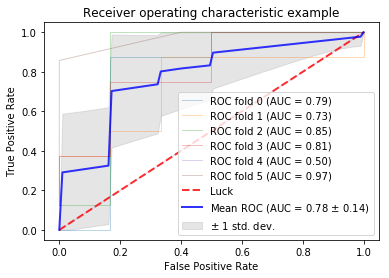

In [20]:
meu.draw_cv_roc_curve(trained_svm, cv_svm, train_x, train_y)

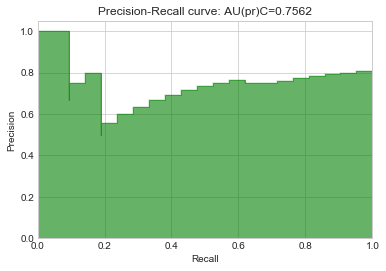

In [21]:
meu.plot_precision_recall_curve(trained_svm, test_x, test_y)

## Build a Random Forest Classifier

In [22]:
clf = RandomForestClassifier()
trained_model = clf.fit(train_x, train_y)

### Evaluation

In [23]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

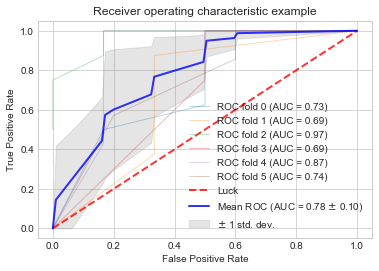

In [24]:
# Creating ROC Curve with Cross Validation
meu.draw_cv_roc_curve(clf, cv, train_x, train_y)

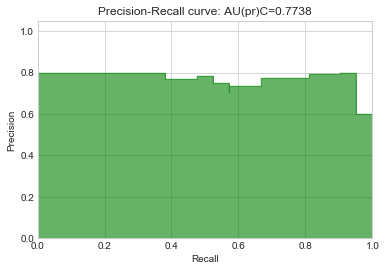

In [25]:
# Plotting Precision Recall Curve
meu.plot_precision_recall_curve(clf, test_x, test_y)

In [26]:
predictions = trained_model.predict(test_x)

In [ ]:
# Train and Test Accuracy
print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))
print(" Confusion matrix ", confusion_matrix(test_y, predictions))

In [ ]:
meu.show_confusion_matrix(confusion_matrix(test_y, predictions))

### Extracting Important Features

In [ ]:
importances = trained_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(train_x.shape[1]):
for f in range(25): 
    column = train_x.columns[indices[f]]
    print("{ranking}. feature {column} ({importance})".format(ranking=f+1,
                                                             column=column,
                                                             importance=importances[indices[f]]))

In [ ]:
# Plot the feature importances of the forest
top_features = 10
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(top_features),
        importances[indices[0:top_features]],
        color="r",
        yerr=std[indices[0:top_features]],
        align="center")
plt.xticks(range(top_features), train_x.columns[indices[0:top_features]])
plt.xlim([-1, top_features])
plt.show()